<font color = green>Final Project- Study and prediction mental illness </font>
--
<font color = green> Submitted By : Able Raj Karimpanakal Rajan, Abhay Bokhiriya, Anvesh Chamakuri, Jeshurun Himadeep Setty</font>
--
<font color = green>Group - 47</font>
--

In [54]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

In [55]:
from scipy import stats
from scipy.stats import randint 

# prep
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.preprocessing import binarize, LabelEncoder, MinMaxScaler

# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# Validation libraries
from sklearn import metrics
from sklearn.metrics import accuracy_score, mean_squared_error, precision_recall_curve
from sklearn.model_selection import cross_val_score

#Bagging
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

#Naive bayes
from sklearn.naive_bayes import GaussianNB 

#Stacking
from mlxtend.classifier import StackingClassifier

In [57]:
train_df = pd.read_csv('survey.csv')


In [58]:
print(train_df.shape)

(1259, 27)


In [59]:
print(train_df.describe())

                Age
count  1.259000e+03
mean   7.942815e+07
std    2.818299e+09
min   -1.726000e+03
25%    2.700000e+01
50%    3.100000e+01
75%    3.600000e+01
max    1.000000e+11


In [61]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Timestamp                  1259 non-null   object
 1   Age                        1259 non-null   int64 
 2   Gender                     1259 non-null   object
 3   Country                    1259 non-null   object
 4   state                      744 non-null    object
 5   self_employed              1241 non-null   object
 6   family_history             1259 non-null   object
 7   treatment                  1259 non-null   object
 8   work_interfere             995 non-null    object
 9   no_employees               1259 non-null   object
 10  remote_work                1259 non-null   object
 11  tech_company               1259 non-null   object
 12  benefits                   1259 non-null   object
 13  care_options               1259 non-null   object
 14  wellness

In [62]:
train_df = train_df.drop(['comments'], axis= 1)
train_df = train_df.drop(['state'], axis= 1)
train_df = train_df.drop(['Timestamp'], axis= 1)

train_df.isnull().sum().max() #just checking that there's no missing data missing...
train_df.head(5)

,Age,Gender,Country,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,37,Female,United States,NaN,No,Yes,Often,6-25,No,Yes,Yes,Not sure,No,Yes,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No
1,44,M,United States,NaN,No,No,Rarely,More than 1000,No,No,Don't know,No,Don't know,Don't know,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No
2,32,Male,Canada,NaN,No,No,Rarely,6-25,No,Yes,No,No,No,No,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No
3,31,Male,United Kingdom,NaN,Yes,Yes,Often,26-100,No,Yes,No,Yes,No,No,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes
4,31,Male,United States,NaN,No,No,Never,100-500,Yes,Yes,Yes,No,Don't know,Don't know,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No


In [63]:
defaultInt = 0
defaultString = 'NaN'
defaultFloat = 0.0

# Create lists by data tpe
intFeatures = ['Age']
stringFeatures = ['Gender', 'Country', 'self_employed', 'family_history', 'treatment', 'work_interfere',
                 'no_employees', 'remote_work', 'tech_company', 'anonymity', 'leave', 'mental_health_consequence',
                 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview',
                 'mental_vs_physical', 'obs_consequence', 'benefits', 'care_options', 'wellness_program',
                 'seek_help']
floatFeatures = []

# Clean the NaN's
for feature in train_df:
    if feature in intFeatures:
        train_df[feature] = train_df[feature].fillna(defaultInt)
    elif feature in stringFeatures:
        train_df[feature] = train_df[feature].fillna(defaultString)
    elif feature in floatFeatures:
        train_df[feature] = train_df[feature].fillna(defaultFloat)
    else:
        print('Error: Feature %s not recognized.' % feature)
train_df.head(5)

,Age,Gender,Country,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,37,Female,United States,NaN,No,Yes,Often,6-25,No,Yes,Yes,Not sure,No,Yes,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No
1,44,M,United States,NaN,No,No,Rarely,More than 1000,No,No,Don't know,No,Don't know,Don't know,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No
2,32,Male,Canada,NaN,No,No,Rarely,6-25,No,Yes,No,No,No,No,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No
3,31,Male,United Kingdom,NaN,Yes,Yes,Often,26-100,No,Yes,No,Yes,No,No,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes
4,31,Male,United States,NaN,No,No,Never,100-500,Yes,Yes,Yes,No,Don't know,Don't know,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No


In [64]:
#clean 'Gender'
#Slower case all columm's elements
gender = train_df['Gender'].str.lower()
#print(gender)

#Select unique elements
gender = train_df['Gender'].unique()

#Made gender groups
male_str = ["male", "m", "male-ish", "maile", "mal", "male (cis)", "make", "male ", "man","msle", "mail", "malr","cis man", "Cis Male", "cis male"]
trans_str = ["trans-female", "something kinda male?", "queer/she/they", "non-binary","nah", "all", "enby", "fluid", "genderqueer", "androgyne", "agender", "male leaning androgynous", "guy (-ish) ^_^", "trans woman", "neuter", "female (trans)", "queer", "ostensibly male, unsure what that really means"]           
female_str = ["cis female", "f", "female", "woman",  "femake", "female ","cis-female/femme", "female (cis)", "femail"]

for (row, col) in train_df.iterrows():

    if str.lower(col.Gender) in male_str:
        train_df['Gender'].replace(to_replace=col.Gender, value='male', inplace=True)

    if str.lower(col.Gender) in female_str:
        train_df['Gender'].replace(to_replace=col.Gender, value='female', inplace=True)

    if str.lower(col.Gender) in trans_str:
        train_df['Gender'].replace(to_replace=col.Gender, value='trans', inplace=True)

#Get rid of bullshit
stk_list = ['A little about you', 'p']
train_df = train_df[~train_df['Gender'].isin(stk_list)]

print(train_df['Gender'].unique())

['female' 'male' 'trans']


In [65]:
#complete missing age with mean
train_df['Age'].fillna(train_df['Age'].median(), inplace = True)

# Fill with median() values < 18 and > 120
s = pd.Series(train_df['Age'])
s[s<18] = train_df['Age'].median()
train_df['Age'] = s
s = pd.Series(train_df['Age'])
s[s>120] = train_df['Age'].median()
train_df['Age'] = s

#Ranges of Age
train_df['age_range'] = pd.cut(train_df['Age'], [0,20,30,65,100], labels=["0-20", "21-30", "31-65", "66-100"], include_lowest=True)

In [66]:
#There are only 0.014% of self employed so let's change NaN to NOT self_employed
#Replace "NaN" string from defaultString
train_df['self_employed'] = train_df['self_employed'].replace([defaultString], 'No')
print(train_df['self_employed'].unique())

['No' 'Yes']


In [67]:
train_df['work_interfere'] = train_df['work_interfere'].replace([defaultString], 'Don\'t know' )
print(train_df['work_interfere'].unique())

['Often' 'Rarely' 'Never' 'Sometimes' "Don't know"]


In [68]:
labelDict = {}
for feature in train_df:
    le = preprocessing.LabelEncoder()
    le.fit(train_df[feature])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    train_df[feature] = le.transform(train_df[feature])
    # Get labels
    labelKey = 'label_' + feature
    labelValue = [*le_name_mapping]
    labelDict[labelKey] =labelValue
    
for key, value in labelDict.items():     
    print(key, value)

#Get rid of 'Country'
train_df = train_df.drop(['Country'], axis= 1)
train_df.head()

label_Age [18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 60, 61, 62, 65, 72]
label_Gender ['female', 'male', 'trans']
label_Country ['Australia', 'Austria', 'Belgium', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Canada', 'China', 'Colombia', 'Costa Rica', 'Croatia', 'Czech Republic', 'Denmark', 'Finland', 'France', 'Georgia', 'Germany', 'Greece', 'Hungary', 'India', 'Ireland', 'Israel', 'Italy', 'Japan', 'Latvia', 'Mexico', 'Moldova', 'Netherlands', 'New Zealand', 'Nigeria', 'Norway', 'Philippines', 'Poland', 'Portugal', 'Romania', 'Russia', 'Singapore', 'Slovenia', 'South Africa', 'Spain', 'Sweden', 'Switzerland', 'Thailand', 'United Kingdom', 'United States', 'Uruguay', 'Zimbabwe']
label_self_employed ['No', 'Yes']
label_family_history ['No', 'Yes']
label_treatment ['No', 'Yes']
label_work_interfere ["Don't know", 'Never', 'Often', 'Rarely', 'Sometimes']
label_no_emp

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,age_range
0,19,0,0,0,1,2,4,0,1,2,1,1,2,2,2,1,1,1,2,1,0,2,0,2
1,26,1,0,0,0,3,5,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,2
2,14,1,0,0,0,3,4,0,1,1,0,1,1,0,1,1,1,2,2,2,2,1,0,2
3,13,1,0,1,1,2,2,0,1,1,2,1,1,1,1,2,2,1,0,0,0,1,1,2
4,13,1,0,0,0,1,1,1,1,2,0,0,0,0,0,1,1,1,2,2,2,0,0,2


In [69]:
#missing data
total = train_df.isnull().sum().sort_values(ascending=False)
percent = (train_df.isnull().sum()/train_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)
print(missing_data)

                           Total  Percent
age_range                      0      0.0
obs_consequence                0      0.0
Gender                         0      0.0
self_employed                  0      0.0
family_history                 0      0.0
treatment                      0      0.0
work_interfere                 0      0.0
no_employees                   0      0.0
remote_work                    0      0.0
tech_company                   0      0.0
benefits                       0      0.0
care_options                   0      0.0
wellness_program               0      0.0
seek_help                      0      0.0
anonymity                      0      0.0
leave                          0      0.0
mental_health_consequence      0      0.0
phys_health_consequence        0      0.0
coworkers                      0      0.0
supervisor                     0      0.0
mental_health_interview        0      0.0
phys_health_interview          0      0.0
mental_vs_physical             0  

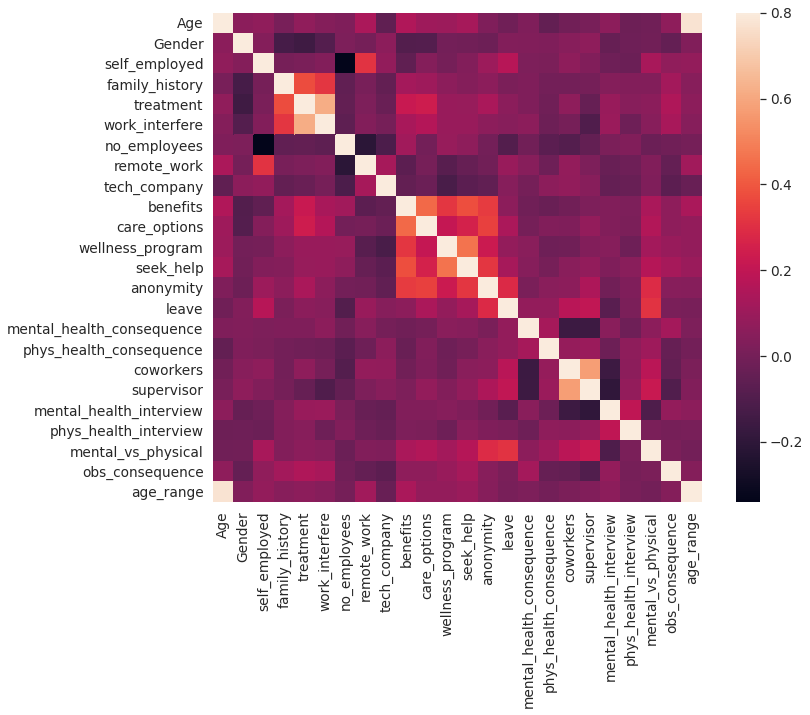

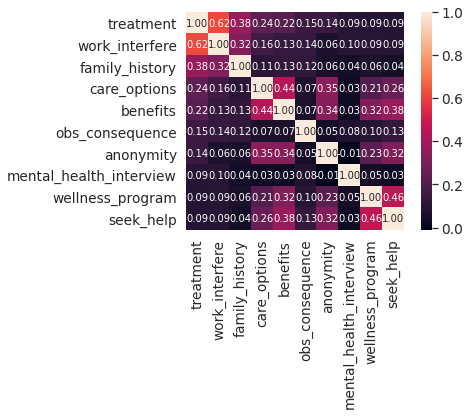

In [70]:
#correlation matrix
corrmat = train_df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);
plt.show()

#treatment correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'treatment')['treatment'].index
cm = np.corrcoef(train_df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Age')

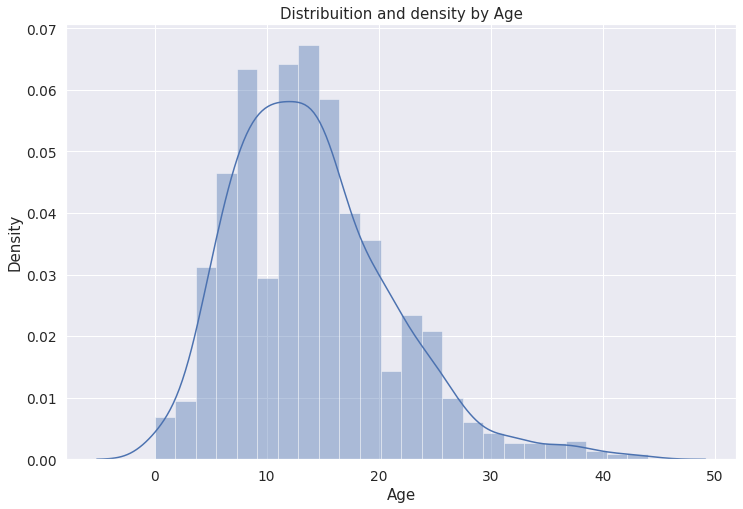

In [71]:
# Distribiution and density by Age
plt.figure(figsize=(12,8))
sns.distplot(train_df["Age"], bins=24)
plt.title("Distribuition and density by Age")
plt.xlabel("Age")

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


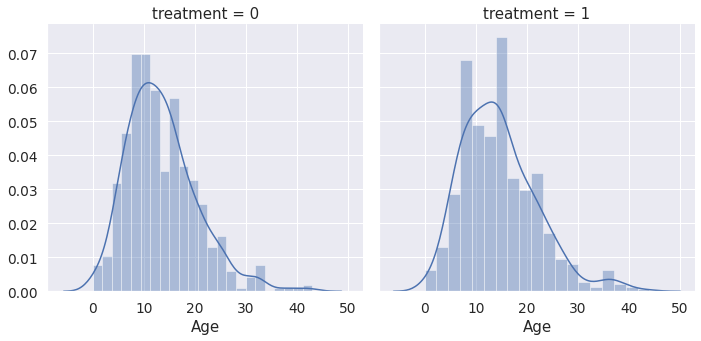

In [72]:
# Separate by treatment or not

g = sns.FacetGrid(train_df, col='treatment', size=5)
g = g.map(sns.distplot, "Age")

Text(0.5, 1.0, 'Total Distribuition by treated or not')

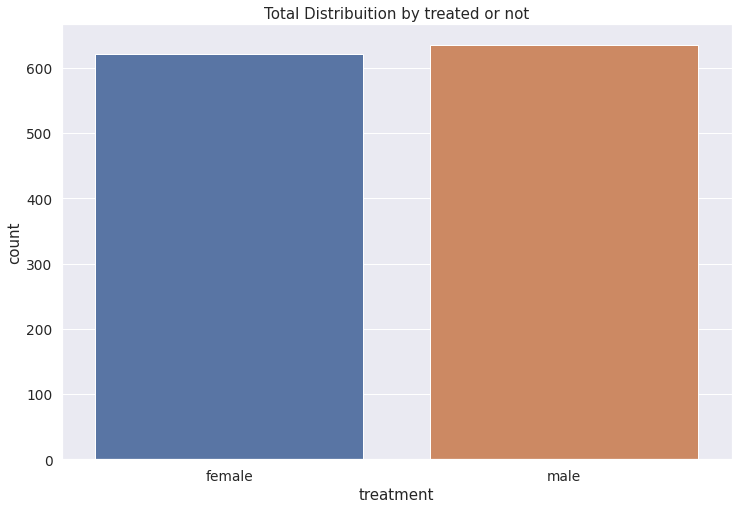

In [73]:
# Let see how many people has been treated
plt.figure(figsize=(12,8))
labels = labelDict['label_Gender']
g = sns.countplot(x="treatment", data=train_df)
g.set_xticklabels(labels)

plt.title('Total Distribuition by treated or not')

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3710: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


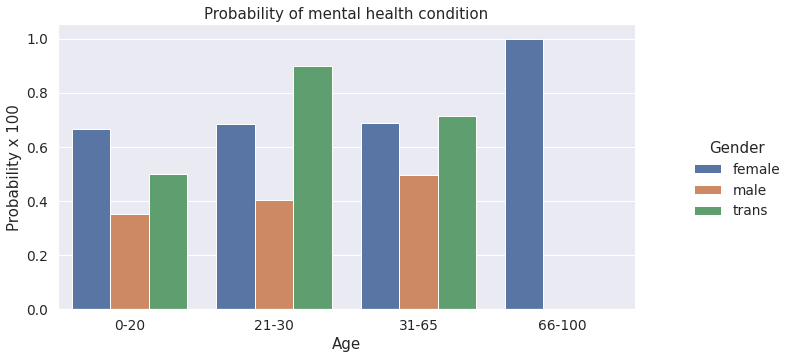

In [74]:
o = labelDict['label_age_range']

g = sns.factorplot(x="age_range", y="treatment", hue="Gender", data=train_df, kind="bar",  ci=None, size=5, aspect=2, legend_out = True)
g.set_xticklabels(o)

plt.title('Probability of mental health condition')
plt.ylabel('Probability x 100')
plt.xlabel('Age')
# replace legend labels

new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

# Positioning the legend
g.fig.subplots_adjust(top=0.9,right=0.8)

plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3710: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


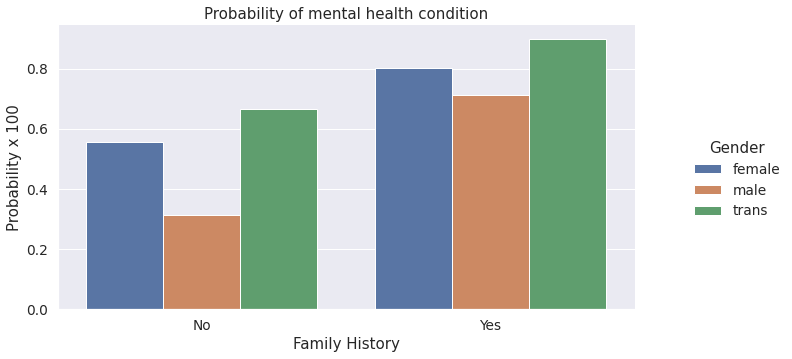

In [75]:
o = labelDict['label_family_history']
g = sns.factorplot(x="family_history", y="treatment", hue="Gender", data=train_df, kind="bar", ci=None, size=5, aspect=2, legend_out = True)
g.set_xticklabels(o)
plt.title('Probability of mental health condition')
plt.ylabel('Probability x 100')
plt.xlabel('Family History')

# replace legend labels
new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

# Positioning the legend
g.fig.subplots_adjust(top=0.9,right=0.8)

plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3710: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


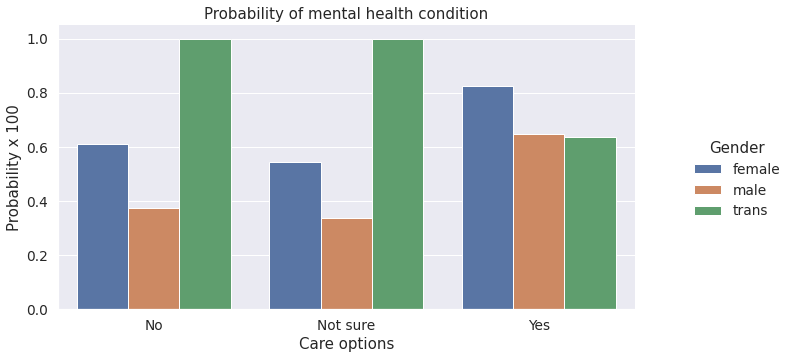

In [76]:
o = labelDict['label_care_options']
g = sns.factorplot(x="care_options", y="treatment", hue="Gender", data=train_df, kind="bar", ci=None, size=5, aspect=2, legend_out = True)
g.set_xticklabels(o)
plt.title('Probability of mental health condition')
plt.ylabel('Probability x 100')
plt.xlabel('Care options')

# replace legend labels
new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

# Positioning the legend
g.fig.subplots_adjust(top=0.9,right=0.8)
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3710: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


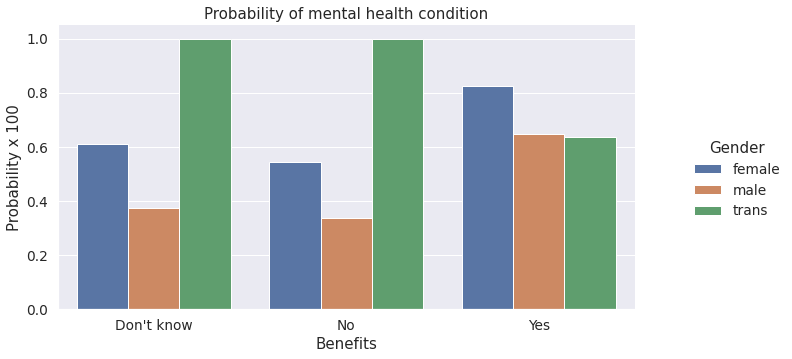

In [77]:
o = labelDict['label_benefits']
g = sns.factorplot(x="care_options", y="treatment", hue="Gender", data=train_df, kind="bar", ci=None, size=5, aspect=2, legend_out = True)
g.set_xticklabels(o)
plt.title('Probability of mental health condition')
plt.ylabel('Probability x 100')
plt.xlabel('Benefits')

# replace legend labels
new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

# Positioning the legend
g.fig.subplots_adjust(top=0.9,right=0.8)
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3710: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


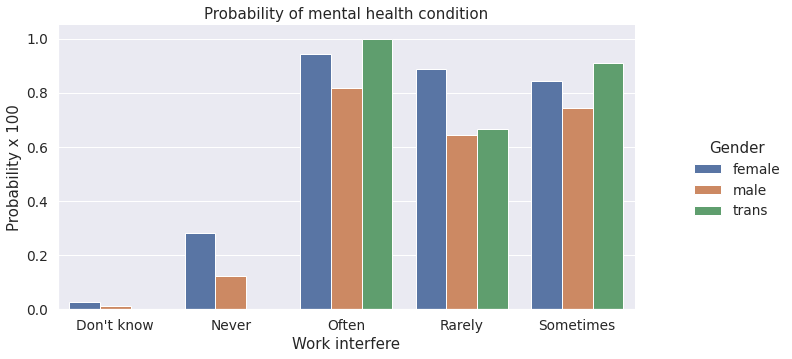

In [78]:
o = labelDict['label_work_interfere']
g = sns.factorplot(x="work_interfere", y="treatment", hue="Gender", data=train_df, kind="bar", ci=None, size=5, aspect=2, legend_out = True)
g.set_xticklabels(o)
plt.title('Probability of mental health condition')
plt.ylabel('Probability x 100')
plt.xlabel('Work interfere')

# replace legend labels
new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

# Positioning the legend
g.fig.subplots_adjust(top=0.9,right=0.8)
plt.show()

In [79]:
# Scaling Age
scaler = MinMaxScaler()
train_df['Age'] = scaler.fit_transform(train_df[['Age']])
train_df.head()

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,age_range
0,0.431818,0,0,0,1,2,4,0,1,2,1,1,2,2,2,1,1,1,2,1,0,2,0,2
1,0.590909,1,0,0,0,3,5,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,2
2,0.318182,1,0,0,0,3,4,0,1,1,0,1,1,0,1,1,1,2,2,2,2,1,0,2
3,0.295455,1,0,1,1,2,2,0,1,1,2,1,1,1,1,2,2,1,0,0,0,1,1,2
4,0.295455,1,0,0,0,1,1,1,1,2,0,0,0,0,0,1,1,1,2,2,2,0,0,2


In [80]:
# define X and y
feature_cols = ['Age', 'Gender', 'family_history', 'benefits', 'care_options', 'anonymity', 'leave', 'work_interfere']
X = train_df[feature_cols]
y = train_df.treatment

# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

# Create dictionaries for final graph
methodDict = {}
rmseDict = ()

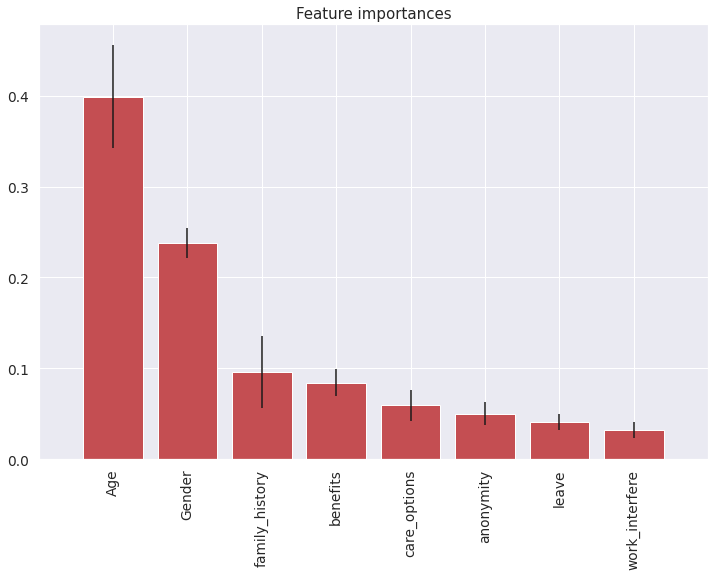

In [81]:
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=53)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

labels = []
for f in range(X.shape[1]):
    labels.append(feature_cols[f])      
    
# Plot the feature importances of the forest
plt.figure(figsize=(12,8))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), labels, rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.show()

## Modeling

In [82]:
def evalClassModel(model, y_test, y_pred_class, plot=False):
    #Classification accuracy: percentage of correct predictions
    # calculate accuracy
    print('Accuracy:', metrics.accuracy_score(y_test, y_pred_class))
    
    #Confusion matrix
    confusion = metrics.confusion_matrix(y_test, y_pred_class)
    #[row, column]
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    
    # visualizing Confusion Matrix
    sns.heatmap(confusion,annot=True,fmt="d") 
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    #Metrics computed from a confusion matrix
    #Classification Accuracy
    accuracy = metrics.accuracy_score(y_test, y_pred_class)
    print('Classification Accuracy:', accuracy)
    
    #Classification Error
    print('Classification Error:', 1 - metrics.accuracy_score(y_test, y_pred_class))
    
    #False Positive Rate: When the actual value is negative, how often is the prediction incorrect?
    false_positive_rate = FP / float(TN + FP)
    print('False Positive Rate:', false_positive_rate)
    
    #Precision: When a positive value is predicted, how often is the prediction correct?
    print('Precision:', metrics.precision_score(y_test, y_pred_class))
    
    
    print('AUC Score:', metrics.roc_auc_score(y_test, y_pred_class))
    
    # calculate cross-validated AUC
    print('Cross-validated AUC:', cross_val_score(model, X, y, cv=10, scoring='roc_auc').mean())
    
    # print the first 10 predicted responses
    # 1D array (vector) of binary values (0, 1)
    print('First 10 predicted responses:\n', model.predict(X_test)[0:10])

    # print the first 10 predicted probabilities of class membership
    print('First 10 predicted probabilities of class members:\n', model.predict_proba(X_test)[0:10])

    # print the first 10 predicted probabilities for class 1
    model.predict_proba(X_test)[0:10, 1]
    
    # store the predicted probabilities for class 1
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    
    if plot == True:
        # histogram of predicted probabilities
        # adjust the font size 
        plt.rcParams['font.size'] = 12
        # 8 bins
        plt.hist(y_pred_prob, bins=8)
        
        # x-axis limit from 0 to 1
        plt.xlim(0,1)
        plt.title('Histogram of predicted probabilities')
        plt.xlabel('Predicted probability of treatment')
        plt.ylabel('Frequency')
    
    
    # predict treatment if the predicted probability is greater than 0.3
    # it will return 1 for all values above 0.3 and 0 otherwise
    y_pred_prob = y_pred_prob.reshape(-1,1) 
    y_pred_class = binarize(y_pred_prob, 0.3)[0]
    
    # print the first 10 predicted probabilities
    print('First 10 predicted probabilities:\n', y_pred_prob[0:10])
    
    #ROC Curves and Area Under the Curve (AUC)
    
    roc_auc = metrics.roc_auc_score(y_test, y_pred_prob)
    
    
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
    if plot == True:
        plt.figure()
        
        plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.rcParams['font.size'] = 12
        plt.title('ROC curve for treatment classifier')
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.legend(loc="lower right")
        plt.show()
    
    # define a function that accepts a threshold and prints sensitivity and specificity
    def evaluate_threshold(threshold):
        print('Specificity for ' + str(threshold) + ' :', 1 - fpr[thresholds > threshold][-1])

    # Setting threshold
    predict_mine = np.where(y_pred_prob > 0.50, 1, 0)
    confusion = metrics.confusion_matrix(y_test, predict_mine)
    print(confusion)
    
    
    
    return accuracy

In [83]:
# Tuning with cross validation score
def tuningCV(knn):
    
    # search for an optimal value of K for KNN
    k_range = list(range(1, 31))
    k_scores = []
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
        k_scores.append(scores.mean())
    print(k_scores)
    # plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
    plt.plot(k_range, k_scores)
    plt.xlabel('Value of K for KNN')
    plt.ylabel('Cross-Validated Accuracy')
    plt.show()

In [84]:
def tuningGridSerach(knn):
    #More efficient parameter tuning using GridSearchCV
    # define the parameter values that should be searched
    k_range = list(range(1, 31))
    print(k_range)
    
    # create a parameter grid: map the parameter names to the values that should be searched
    param_grid = dict(n_neighbors=k_range)
    print(param_grid)
    
    # instantiate the grid
    grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')

    # fit the grid with data
    grid.fit(X, y)
    
    # view the complete results (list of named tuples)
    grid.grid_scores_
    
    # examine the first tuple
    print(grid.grid_scores_[0].parameters)
    print(grid.grid_scores_[0].cv_validation_scores)
    print(grid.grid_scores_[0].mean_validation_score)
    
    # create a list of the mean scores only
    grid_mean_scores = [result.mean_validation_score for result in grid.grid_scores_]
    print(grid_mean_scores)
    
    # plot the results
    plt.plot(k_range, grid_mean_scores)
    plt.xlabel('Value of K for KNN')
    plt.ylabel('Cross-Validated Accuracy')
    plt.show()
    
    # examine the best model
    print('GridSearch best score', grid.best_score_)
    print('GridSearch best params', grid.best_params_)
    print('GridSearch best estimator', grid.best_estimator_)

In [85]:
def tuningRandomizedSearchCV(model, param_dist):
    #Searching multiple parameters simultaneously
    # n_iter controls the number of searches
    rand = RandomizedSearchCV(model, param_dist, cv=10, scoring='accuracy', n_iter=10, random_state=53)
    rand.fit(X, y)
    rand.cv_results_
    
    # examine the best model
    print('Rand. Best Score: ', rand.best_score_)
    print('Rand. Best Params: ', rand.best_params_)
    
    # run RandomizedSearchCV 20 times (with n_iter=10) and record the best score
    best_scores = []
    for _ in range(20):
        rand = RandomizedSearchCV(model, param_dist, cv=10, scoring='accuracy', n_iter=10)
        rand.fit(X, y)
        best_scores.append(round(rand.best_score_, 3))
    print(best_scores)

In [86]:
def tuningMultParam(knn):
    
    #Searching multiple parameters simultaneously
    # define the parameter values that should be searched
    k_range = list(range(1, 31))
    weight_options = ['uniform', 'distance']
        
    # create a parameter grid: map the parameter names to the values that should be searched
    param_grid = dict(n_neighbors=k_range, weights=weight_options)
    print(param_grid) 
    
    # instantiate and fit the grid
    grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
    grid.fit(X, y) 
    
    # view the complete results
    print(grid.grid_scores_)
    
    # examine the best model
    print('Multiparam. Best Score: ', grid.best_score_)

### LogisticRegression

In [87]:
def logisticRegression():
    # train a logistic regression model on the training set
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    
    # make class predictions for the testing set
    y_pred_class = logreg.predict(X_test)
    
    print('Logistic Regression ')
    
    accuracy_score = evalClassModel(logreg, y_test, y_pred_class, True)
    
    #Data for final graph
    methodDict['Log. Regres.'] = accuracy_score * 100

Logistic Regression 
Accuracy: 0.7962962962962963


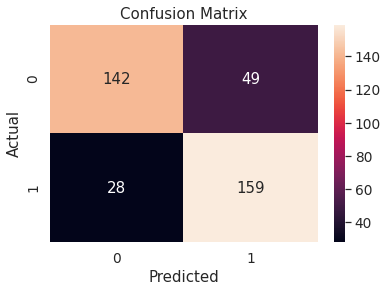

Classification Accuracy: 0.7962962962962963
Classification Error: 0.20370370370370372
False Positive Rate: 0.25654450261780104
Precision: 0.7644230769230769
AUC Score: 0.7968614385306716
Cross-validated AUC: 0.8753623882722146
First 10 predicted responses:
 [1 0 0 0 1 1 0 1 0 1]
First 10 predicted probabilities of class members:
 [[0.09193053 0.90806947]
 [0.95991564 0.04008436]
 [0.96547467 0.03452533]
 [0.78757121 0.21242879]
 [0.38959922 0.61040078]
 [0.05264207 0.94735793]
 [0.75035574 0.24964426]
 [0.19065116 0.80934884]
 [0.61612081 0.38387919]
 [0.47699963 0.52300037]]
First 10 predicted probabilities:
 [[0.90806947]
 [0.04008436]
 [0.03452533]
 [0.21242879]
 [0.61040078]
 [0.94735793]
 [0.24964426]
 [0.80934884]
 [0.38387919]
 [0.52300037]]


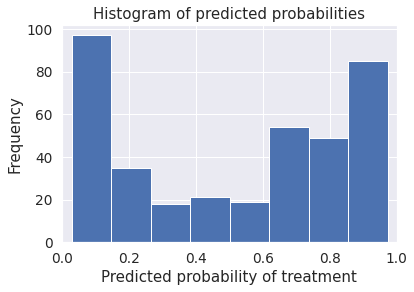

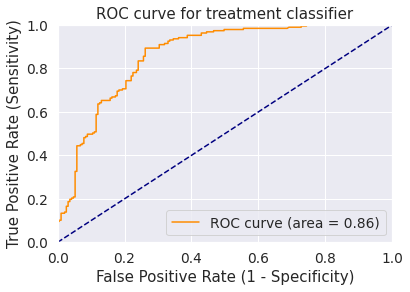

[[142  49]
 [ 28 159]]


In [88]:
logisticRegression()

### KNN

In [89]:
def Knn():
    # Calculating the best parameters
    knn = KNeighborsClassifier(n_neighbors=5)
        
    # define the parameter values that should be searched
    k_range = list(range(1, 31))
    weight_options = ['uniform', 'distance']
    
    # specify "parameter distributions" rather than a "parameter grid"
    param_dist = dict(n_neighbors=k_range, weights=weight_options)
    tuningRandomizedSearchCV(knn, param_dist)
    
    # train a KNeighborsClassifier model on the training set
    knn = KNeighborsClassifier(n_neighbors=27, weights='uniform')
    knn.fit(X_train, y_train)
    
    # make class predictions for the testing set
    y_pred_class = knn.predict(X_test)
    
    print('KNeighborsClassifier')
    
    accuracy_score = evalClassModel(knn, y_test, y_pred_class, True)

    #Data for final graph
    methodDict['KNN'] = accuracy_score * 100

Rand. Best Score:  0.8225904761904761
Rand. Best Params:  {'weights': 'uniform', 'n_neighbors': 19}
[0.819, 0.815, 0.812, 0.823, 0.823, 0.821, 0.821, 0.815, 0.818, 0.812, 0.818, 0.823, 0.823, 0.815, 0.816, 0.819, 0.82, 0.815, 0.821, 0.819]
KNeighborsClassifier
Accuracy: 0.8042328042328042


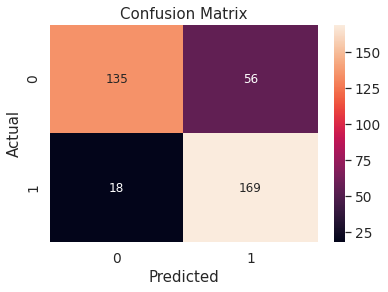

Classification Accuracy: 0.8042328042328042
Classification Error: 0.1957671957671958
False Positive Rate: 0.2931937172774869
Precision: 0.7511111111111111
AUC Score: 0.8052747991152673
Cross-validated AUC: 0.8782819116296456
First 10 predicted responses:
 [1 0 0 0 1 1 0 1 1 1]
First 10 predicted probabilities of class members:
 [[0.33333333 0.66666667]
 [1.         0.        ]
 [1.         0.        ]
 [0.66666667 0.33333333]
 [0.37037037 0.62962963]
 [0.03703704 0.96296296]
 [0.59259259 0.40740741]
 [0.37037037 0.62962963]
 [0.33333333 0.66666667]
 [0.33333333 0.66666667]]
First 10 predicted probabilities:
 [[0.66666667]
 [0.        ]
 [0.        ]
 [0.33333333]
 [0.62962963]
 [0.96296296]
 [0.40740741]
 [0.62962963]
 [0.66666667]
 [0.66666667]]


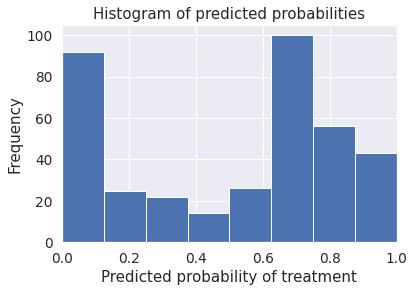

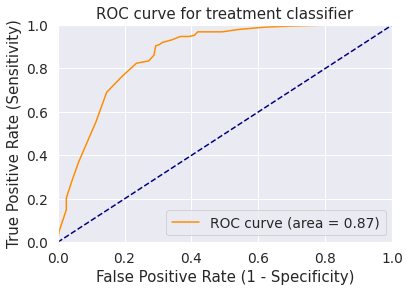

[[135  56]
 [ 18 169]]


In [90]:
Knn()

### TreeClassifier

In [91]:
def treeClassifier():
    # Calculating the best parameters
    tree = DecisionTreeClassifier()
    featuresSize = feature_cols.__len__()
    param_dist = {"max_depth": [3, None],
              "max_features": randint(1, featuresSize),
              "min_samples_split": randint(2, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}
    tuningRandomizedSearchCV(tree, param_dist)
    
    # train a decision tree model on the training set
    tree = DecisionTreeClassifier(max_depth=3, min_samples_split=8, max_features=6, criterion='entropy', min_samples_leaf=7)
    tree.fit(X_train, y_train)
    
    # make class predictions for the testing set
    y_pred_class = tree.predict(X_test)
    
    print(' Tree classifier')
    
    accuracy_score = evalClassModel(tree, y_test, y_pred_class, True)

    #Data for final graph
    methodDict['Tree clas.'] = accuracy_score * 100

Rand. Best Score:  0.8289333333333333
Rand. Best Params:  {'criterion': 'gini', 'max_depth': 3, 'max_features': 6, 'min_samples_leaf': 3, 'min_samples_split': 7}
[0.831, 0.83, 0.83, 0.829, 0.831, 0.831, 0.824, 0.829, 0.831, 0.831, 0.83, 0.83, 0.831, 0.831, 0.829, 0.817, 0.831, 0.823, 0.831, 0.83]
 Tree classifier
Accuracy: 0.8068783068783069


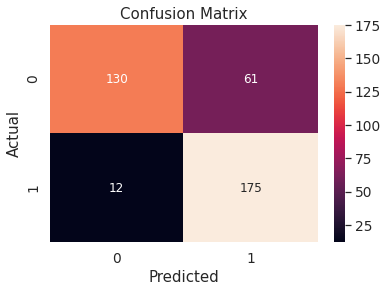

Classification Accuracy: 0.8068783068783069
Classification Error: 0.19312169312169314
False Positive Rate: 0.3193717277486911
Precision: 0.7415254237288136
AUC Score: 0.8082285746283282
Cross-validated AUC: 0.8782785304608701
First 10 predicted responses:
 [1 0 0 0 1 1 0 1 1 1]
First 10 predicted probabilities of class members:
 [[0.18823529 0.81176471]
 [0.97959184 0.02040816]
 [1.         0.        ]
 [0.8778626  0.1221374 ]
 [0.36969697 0.63030303]
 [0.05172414 0.94827586]
 [0.8778626  0.1221374 ]
 [0.36969697 0.63030303]
 [0.20430108 0.79569892]
 [0.20430108 0.79569892]]
First 10 predicted probabilities:
 [[0.81176471]
 [0.02040816]
 [0.        ]
 [0.1221374 ]
 [0.63030303]
 [0.94827586]
 [0.1221374 ]
 [0.63030303]
 [0.79569892]
 [0.79569892]]


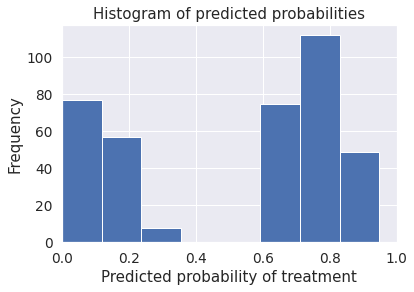

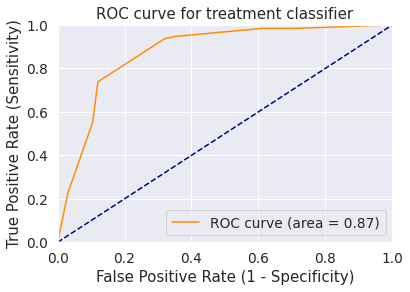

[[130  61]
 [ 12 175]]


In [92]:
treeClassifier()

### RandomForest

In [93]:
def randomForest():
    # Calculating the best parameters
    forest = RandomForestClassifier(n_estimators = 20)

    featuresSize = feature_cols.__len__()
    param_dist = {"max_depth": [3, None],
              "max_features": randint(1, featuresSize),
              "min_samples_split": randint(2, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}
    tuningRandomizedSearchCV(forest, param_dist)
    
    # Building and fitting my_forest
    forest = RandomForestClassifier(max_depth = None, min_samples_leaf=8, min_samples_split=2, n_estimators = 20, random_state = 53)
    my_forest = forest.fit(X_train, y_train)
    
    # make class predictions for the testing set
    y_pred_class = my_forest.predict(X_test)
    
    print('Random Forests')
    
    accuracy_score = evalClassModel(my_forest, y_test, y_pred_class, True)

    #Data for final graph
    methodDict['R. Forest'] = accuracy_score * 100

Rand. Best Score:  0.8305206349206349
Rand. Best Params:  {'criterion': 'entropy', 'max_depth': 3, 'max_features': 5, 'min_samples_leaf': 8, 'min_samples_split': 2}
[0.832, 0.836, 0.833, 0.831, 0.831, 0.832, 0.831, 0.831, 0.831, 0.831, 0.831, 0.831, 0.831, 0.831, 0.828, 0.834, 0.831, 0.831, 0.831, 0.841]
Random Forests
Accuracy: 0.8095238095238095


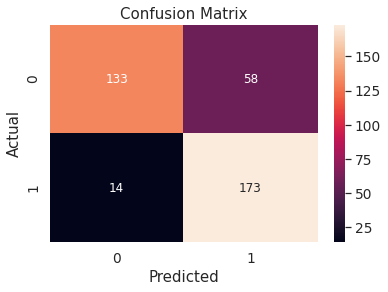

Classification Accuracy: 0.8095238095238095
Classification Error: 0.19047619047619047
False Positive Rate: 0.3036649214659686
Precision: 0.7489177489177489
AUC Score: 0.8107343841868019
Cross-validated AUC: 0.8964644657893027
First 10 predicted responses:
 [1 0 0 0 1 1 0 1 1 1]
First 10 predicted probabilities of class members:
 [[0.25124489 0.74875511]
 [0.9780887  0.0219113 ]
 [0.98584416 0.01415584]
 [0.87730664 0.12269336]
 [0.46623401 0.53376599]
 [0.12179642 0.87820358]
 [0.79784594 0.20215406]
 [0.47144284 0.52855716]
 [0.24750741 0.75249259]
 [0.16884848 0.83115152]]
First 10 predicted probabilities:
 [[0.74875511]
 [0.0219113 ]
 [0.01415584]
 [0.12269336]
 [0.53376599]
 [0.87820358]
 [0.20215406]
 [0.52855716]
 [0.75249259]
 [0.83115152]]


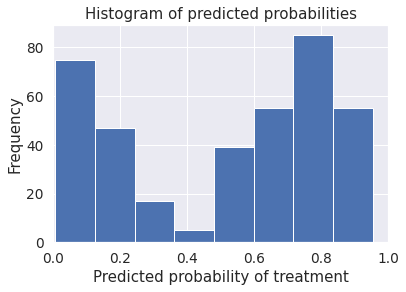

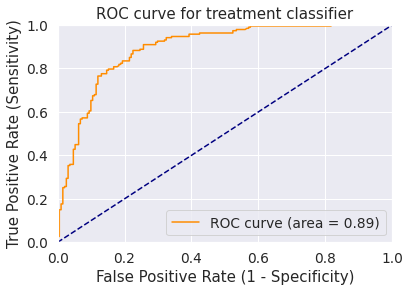

[[133  58]
 [ 14 173]]


In [94]:
randomForest()

### Bagging

In [95]:
def bagging():
    # Building and fitting 
    bag = BaggingClassifier(DecisionTreeClassifier(), max_samples=1.0, max_features=1.0, bootstrap_features=False)
    bag.fit(X_train, y_train)
    
    # make class predictions for the testing set
    y_pred_class = bag.predict(X_test)
    
    print('Bagging')
    
    accuracy_score = evalClassModel(bag, y_test, y_pred_class, True)

    #Data for final graph
    methodDict['Bagging'] = accuracy_score * 100

Bagging
Accuracy: 0.8015873015873016


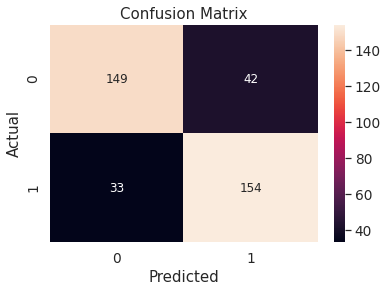

Classification Accuracy: 0.8015873015873016
Classification Error: 0.19841269841269837
False Positive Rate: 0.2198952879581152
Precision: 0.7857142857142857
AUC Score: 0.8018170619032953
Cross-validated AUC: 0.8461625861515454
First 10 predicted responses:
 [1 0 0 0 0 1 0 0 1 1]
First 10 predicted probabilities of class members:
 [[0.13333333 0.86666667]
 [1.         0.        ]
 [1.         0.        ]
 [0.7        0.3       ]
 [0.7        0.3       ]
 [0.3        0.7       ]
 [0.8        0.2       ]
 [0.5        0.5       ]
 [0.3        0.7       ]
 [0.         1.        ]]
First 10 predicted probabilities:
 [[0.86666667]
 [0.        ]
 [0.        ]
 [0.3       ]
 [0.3       ]
 [0.7       ]
 [0.2       ]
 [0.5       ]
 [0.7       ]
 [1.        ]]


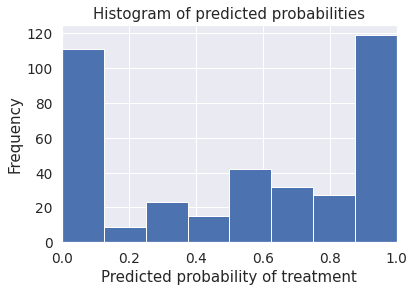

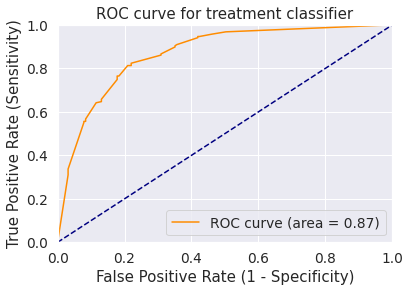

[[149  42]
 [ 33 154]]


In [96]:
bagging()

### Boosting

In [97]:
def boosting():
    # Building and fitting 
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=1)
    boost = AdaBoostClassifier(base_estimator=clf, n_estimators=500)
    boost.fit(X_train, y_train)
    
    # make class predictions for the testing set
    y_pred_class = boost.predict(X_test)
    
    print(' Boosting ')
    
    accuracy_score = evalClassModel(boost, y_test, y_pred_class, True)

    #Data for final graph
    methodDict['Boosting'] = accuracy_score * 100

 Boosting 
Accuracy: 0.8174603174603174


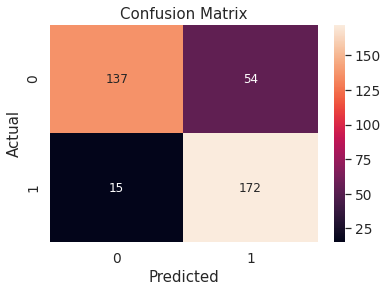

Classification Accuracy: 0.8174603174603174
Classification Error: 0.18253968253968256
False Positive Rate: 0.28272251308900526
Precision: 0.7610619469026548
AUC Score: 0.8185317915838397
Cross-validated AUC: 0.8746279095195426
First 10 predicted responses:
 [1 0 0 0 0 1 0 1 1 1]
First 10 predicted probabilities of class members:
 [[0.49924555 0.50075445]
 [0.50285507 0.49714493]
 [0.50291786 0.49708214]
 [0.50127788 0.49872212]
 [0.50013552 0.49986448]
 [0.49796157 0.50203843]
 [0.50046371 0.49953629]
 [0.49939483 0.50060517]
 [0.49921757 0.50078243]
 [0.49897133 0.50102867]]
First 10 predicted probabilities:
 [[0.50075445]
 [0.49714493]
 [0.49708214]
 [0.49872212]
 [0.49986448]
 [0.50203843]
 [0.49953629]
 [0.50060517]
 [0.50078243]
 [0.50102867]]


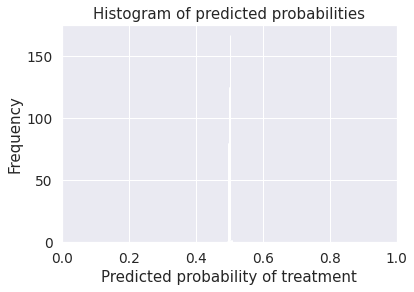

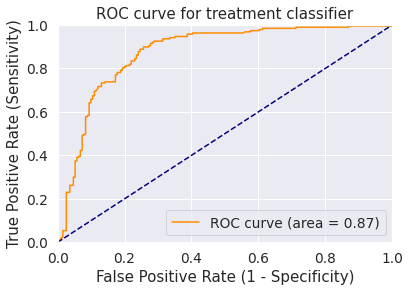

[[137  54]
 [ 15 172]]


In [99]:
boosting()

### Stacking

In [100]:
def stacking():
    # Building and fitting 
    clf1 = KNeighborsClassifier(n_neighbors=1)
    clf2 = RandomForestClassifier(random_state=53)
    clf3 = GaussianNB()
    lr = LogisticRegression()
    stack = StackingClassifier(classifiers=[clf1, clf2, clf3], meta_classifier=lr)
    stack.fit(X_train, y_train)
    
    # make class predictions for the testing set
    y_pred_class = stack.predict(X_test)
    
    print('Stacking ')
    
    accuracy_score = evalClassModel(stack, y_test, y_pred_class, True)

    #Data for final graph
    methodDict['Stacking'] = accuracy_score * 100

Stacking 
Accuracy: 0.8095238095238095


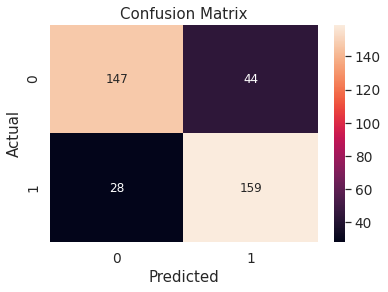

Classification Accuracy: 0.8095238095238095
Classification Error: 0.19047619047619047
False Positive Rate: 0.23036649214659685
Precision: 0.7832512315270936
AUC Score: 0.8099504437662737
Cross-validated AUC: 0.843165832454547
First 10 predicted responses:
 [1 0 0 0 0 1 0 0 1 1]
First 10 predicted probabilities of class members:
 [[0.01156527 0.98843473]
 [0.9919145  0.0080855 ]
 [0.9919145  0.0080855 ]
 [0.9919145  0.0080855 ]
 [0.9919145  0.0080855 ]
 [0.01156527 0.98843473]
 [0.9919145  0.0080855 ]
 [0.98134303 0.01865697]
 [0.02656455 0.97343545]
 [0.01156527 0.98843473]]
First 10 predicted probabilities:
 [[0.98843473]
 [0.0080855 ]
 [0.0080855 ]
 [0.0080855 ]
 [0.0080855 ]
 [0.98843473]
 [0.0080855 ]
 [0.01865697]
 [0.97343545]
 [0.98843473]]


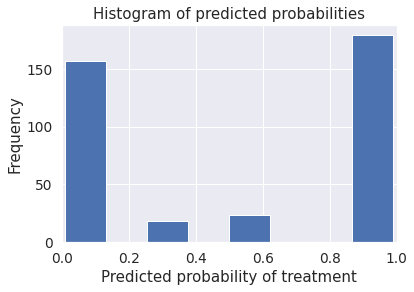

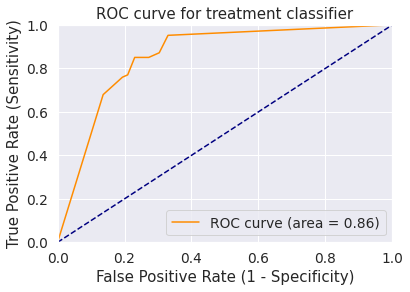

[[147  44]
 [ 28 159]]


In [101]:
stacking()

### PlotSuccess

In [102]:
def plotSuccess():
    s = pd.Series(methodDict)
    s = s.sort_values(ascending=False)
    plt.figure(figsize=(12,8))
    #Colors
    ax = s.plot(kind='bar') 
    for p in ax.patches:
        ax.annotate(str(round(p.get_height(),2)), (p.get_x() * 1.005, p.get_height() * 1.005))
    plt.ylim([70.0, 90.0])
    plt.xlabel('Method')
    plt.ylabel('Percentage')
    plt.title('Success of methods')
     
    plt.show()

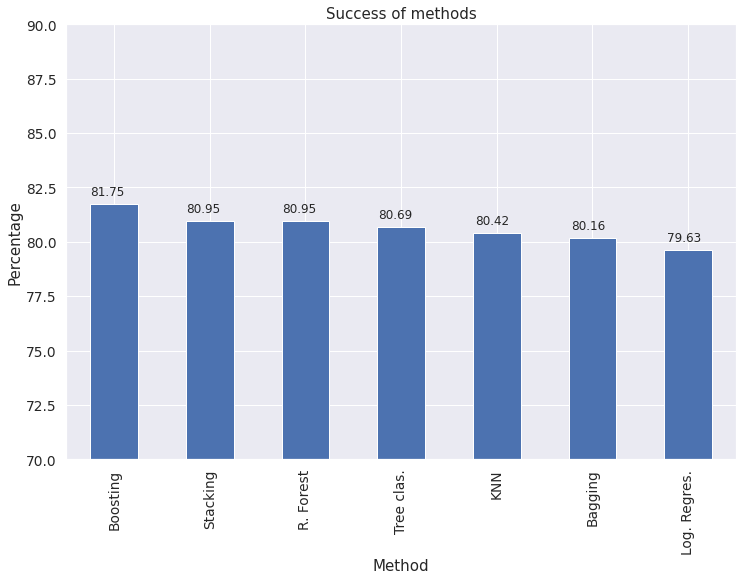

In [103]:
plotSuccess()